# Chapter 07 앙상블 학습과 랜덤 포레스트

In [1]:
# 기본설정

# 파이썬 버전 확인
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 버전 확인
import sklearn
assert sklearn.__version__ >= "0.20"

# 공동 모듈 임포트
import numpy as np
import os

# 그래프 출력 설정
%matplotlib inline
# 위에꺼는 구버전에서 설정해야 되는거였음 설정안해도됨
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ho_chap_07"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)   # exist_ok=True 폴더가 없으면 생성

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()  # 입력없이 사용할 경우 기존에 세팅된 기본값으로 자동 레이아웃 설정
    plt.savefig(path, format=fig_extension, dpi=resolution)  # dpi값 설정을 통해 고해상도 그래프 그리기 가능

## 7.1 투표 기반 분류기
* 앙상블 방법은 예측기가 서로 독립적일 때 최고의 성능을 발휘

In [2]:
# 데이터 받아오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
# 투표기반 분류기
# 분류 모델 받아오기
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

# 직접투표
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [4]:
# 각 분류기 정확도
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.896


In [5]:
# 간접투표
# 모든 분류기가 predict_proba 함수를 가져야함
from sklearn.neighbors import KNeighborsClassifier

svm_clf = SVC(probability=True)  # 모델 생성시 pro 를 True로 해줘야 predict_proba 함수를 사용가능

voting_clf_s = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf_s.fit(X_train, y_train)

y_pred = voting_clf_s.predict(X_test)
print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

VotingClassifier 0.92


간접투표에서 조금 더 성능이 좋게 나옴

## 7.2 배깅과 페이스팅
* 중복을 허용한 샘플링을 배깅
* 중복을 허용하지 않는 샘플링을 페이스팅
* 앙상블을 활용하면 원본 데이터셋으로 하나의 예측기를 훈련시킬떄와 비교해 편향은 비슷하지만 분산은 줄어듬
* 병렬 학습이 가능해 인기가 많음

In [6]:
# 배깅
from sklearn.ensemble import BaggingClassifier # predict_proba() 함수가 있으면 자동으로 간접 두표 방식을 사용
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.92


In [7]:
# 일반 트리
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [8]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

그림 저장: decision_tree_without_and_with_bagging_plot


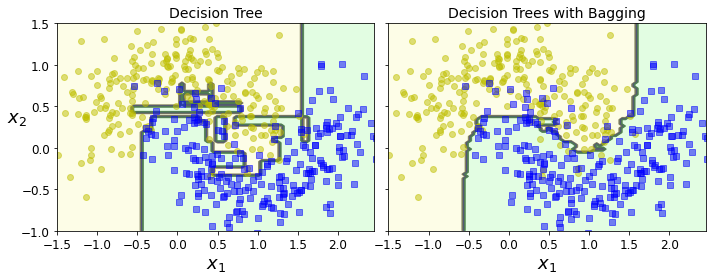

In [9]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

앙상블에서 더 작은 분산을 만들어 일반화가 잘된걸 볼 수 있음.

In [10]:
#페이스팅

pas_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=False, n_jobs=-1)
pas_clf.fit(X_train, y_train)
y_pred = pas_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.912


그림 저장: decision_tree_without_and_with_pasting_plot


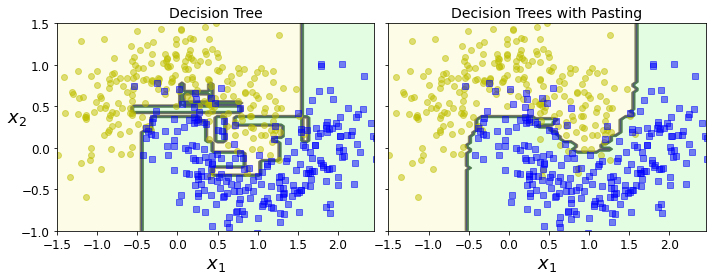

In [11]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(pas_clf, X, y)
plt.title("Decision Trees with Pasting", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_pasting_plot")
plt.show()

부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높음<br/>
But 다양성을 추가하면 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킴.<br/>
일반적으로 배깅이 더 좋음

### 7.2.2 obb 평가
* m개의 샘플에서 무작위로 하나를 추출할 때 선택되지 않을 확률은 
$ (1-\frac{1}{m})^m $
* 여기에 로그를 취하고 로피탈의 정리를 적용하면 $e^-1$과 같아짐
* 따라서 선택되지 않을 확률은 위 값을 1에 뺀 값인 0.63212와 같음
* 선택되지 않은 37%를 oob(out-of-bag)이라고 함

In [12]:
# oob평가 점수
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8933333333333333

In [13]:
# 실제 정확도
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.896

In [14]:
# oob 샘플에 대한 결정 함수값
bag_clf.oob_decision_function_[:5]

array([[0.38251366, 0.61748634],
       [0.27956989, 0.72043011],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

## 7.3 랜덤 패치와 랜덤 서브스페이스
* BaggingCla-는 max_features, bootstrap_features 를 통한 특성 샘플링 지원
* 훈련 특성과 샘플을 모두 샘플링하는 것을 랜덤 패치 방식
* 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것을 랜덤 서브스페이스 방식
* 특성 샘플링은 더 다양한 예측기를 만들어 편향을 늘리는 대신 분산을 낮춤

## 7.4 랜덤 포레스트

In [22]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.92

In [21]:
# BaggingClassifier를 사용해 RandomFo-를 만들기
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred_bag)

0.92

### 7.4.2 특성 중요도

In [23]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, ":",score)

sepal length (cm) : 0.10090544353425772
sepal width (cm) : 0.022020629865448064
petal length (cm) : 0.4341758378510949
petal width (cm) : 0.44289808874919934


### 7.5.1 에이다부스트

In [25]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

y_pred_ada = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred_ada)

0.896

### 7.5.2 그래이디언트 부스팅

In [27]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [28]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [29]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [37]:
y_pred = sum(tree.predict(X_test) for tree in (tree_reg1, tree_reg2, tree_reg3))
# y_pred

In [38]:
# 한번에
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [40]:
# 최적의 모델 찾기
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
        for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=113,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [44]:
# 조기 종료 구현
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break   # 조기종료

In [48]:
# XGB
from xgboost import XGBRegressor

xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

xgb_reg.score(X_test, y_test)

[06:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.8202668477932393

In [49]:
# XGB 자동 조기 종료
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
xgb_reg.score(X_test, y_test)

[06:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.470653
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.44373
[2]	validation_0-rmse:0.421029
[3]	validation_0-rmse:0.401979
[4]	validation_0-rmse:0.38578
[5]	validation_0-rmse:0.372317
[6]	validation_0-rmse:0.360431
[7]	validation_0-rmse:0.351368
[8]	validation_0-rmse:0.342583
[9]	validation_0-rmse:0.336103
[10]	validation_0-rmse:0.329703
[11]	validation_0-rmse:0.324343
[12]	validation_0-rmse:0.319652
[13]	validation_0-rmse:0.315914
[14]	validation_0-rmse:0.313235
[15]	validation_0-rmse:0.307972
[16]	validation_0-rmse:0.306419
[17]	validation_0-rmse:0.302085
[18]	validation_0-rmse:0.299785
[19]	validation_0-rmse:0.297672
[20]	validation_0-rmse:0.294518
[21]	validation_0-rmse:0.293233
[22]	validation_0-rmse:0.291872
[23]	validation_0-rmse:0.291875
[24]	validation_0-rmse:0.289979
[25]	validation_0-rms

0.7667185797543882